<a href="https://colab.research.google.com/github/sayakpaul/SimSiam-TF/blob/main/SimSiam_Pre_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A minimal implementation of **SimSiam** as proposed in [Exploring Simple Siamese Representation Learning](https://arxiv.org/pdf/2011.10566.pdf) by Xinlei Chen and Kaiming He. The objective of this notebook is to demonstrate the workflow of SimSiam and NOT to implement it note to note and at the same time I will try not to miss out on the major bits discussed in the paper. For that matter, I'll be using the Flowers dataset. 

Following depicts the workflow of SimSiam - 

<center>
<img src="https://i.ibb.co/37pNQTP/image.png" width=550></img>
</center>

In [1]:
import tensorflow as tf
print(tf.__version__)

2023-11-24 16:21:57.321781: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-24 16:21:57.321895: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-24 16:21:57.321948: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-24 16:21:57.335669: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.14.0


In [2]:
import tensorflow_datasets as tfds
import tensorflow_addons as tfa

import matplotlib.pyplot as plt
import numpy as np
import random
import time
import os

from tqdm import tqdm

tf.random.set_seed(666)
np.random.seed(666)

tfds.disable_progress_bar()

/users/PAS2301/kibria5/.conda/envs/local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/users/PAS2301/kibria5/.conda/envs/local/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [4]:
# Gather Flowers dataset
train_ds, validation_ds = tfds.load(
    "tf_flowers",
    split=["train[:85%]", "train[85%:]"]
)

2023-11-24 16:22:06.845816: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [5]:
# Gather NISQA voice dataset
dataset_name = f'nisqa/default'

train_sim, train_live, test_sim, test_live = tfds.load(
    dataset_name,
    split=['train_sim', 'train_live', 'test_sim', 'test_live']
)

2023-11-24 16:22:08.000116: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


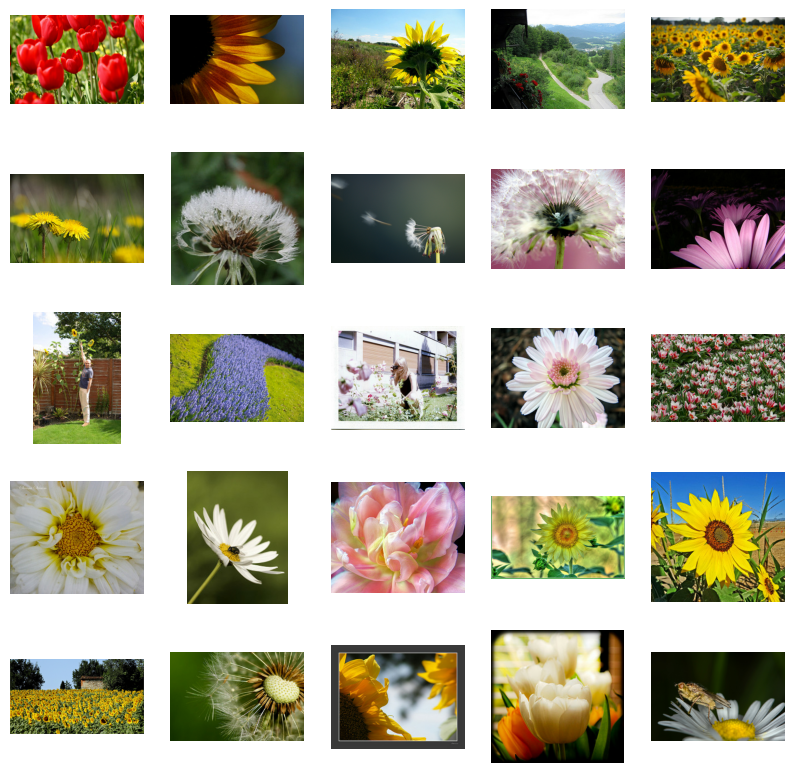

In [6]:
# Visualization
plt.figure(figsize=(10, 10))
for i, image  in enumerate(train_ds.take(25)):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(image['image'])
    plt.axis("off")

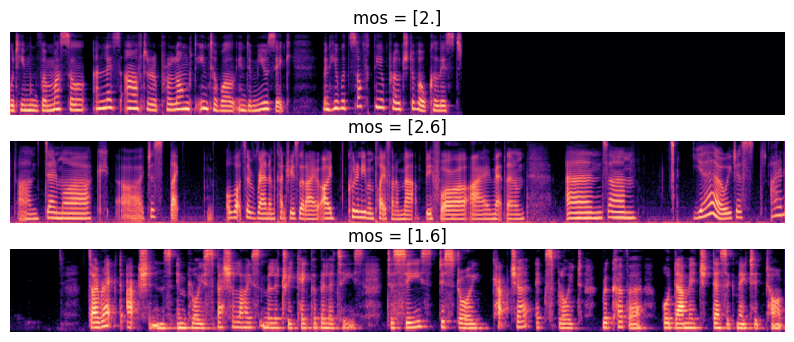

In [7]:
# Spectrogram Visualization
plt.figure(figsize=(10, 4))
for i, audio  in enumerate(train_sim.take(3)):
    ax = plt.subplot(3, 1, i + 1)
    plt.imshow(audio['log_mel_spectogram'], origin="lower", cmap=plt.get_cmap("magma"))
    plt.title('mos = ' + str(audio['mos'].numpy()))
    plt.axis("off") 

Note the augmentation pipeline is a bit different from the augmentations followed in the paper. 

In [8]:
# Reference: https://github.com/google-research/simclr/blob/master/data_util.py

@tf.function
def translate(image):
    (h, w) = tf.shape(image)[0], tf.shape(image)[1]
    image = tf.image.random_flip_left_right(image)

    f = tf.random.uniform([], minval=0, maxval=0.125, dtype=tf.float32)
    (dh, dw) = tf.cast(tf.cast(h, tf.float32)*f, tf.float32), \
        tf.cast(tf.cast(w, tf.float32)*f, tf.float32)
    
    image = tfa.image.translate(image, translations=[dh, dw])
    return image

@tf.function
def gaussian_blur(image, kernel_size=23, padding='SAME'):
    sigma = tf.random.uniform((1,))* 1.9 + 0.1

    radius = tf.cast(kernel_size / 2, tf.int32)
    kernel_size = radius * 2 + 1
    x = tf.cast(tf.range(-radius, radius + 1), tf.float32)
    blur_filter = tf.exp(
        -tf.pow(x, 2.0) / (2.0 * tf.pow(tf.cast(sigma, tf.float32), 2.0)))
    blur_filter /= tf.reduce_sum(blur_filter)
    # One vertical and one horizontal filter.
    blur_v = tf.reshape(blur_filter, [kernel_size, 1, 1, 1])
    blur_h = tf.reshape(blur_filter, [1, kernel_size, 1, 1])
    num_channels = tf.shape(image)[-1]
    blur_h = tf.tile(blur_h, [1, 1, num_channels, 1])
    blur_v = tf.tile(blur_v, [1, 1, num_channels, 1])
    expand_batch_dim = image.shape.ndims == 3
    if expand_batch_dim:
        image = tf.expand_dims(image, axis=0)
    blurred = tf.nn.depthwise_conv2d(
        image, blur_h, strides=[1, 1, 1, 1], padding=padding)
    blurred = tf.nn.depthwise_conv2d(
        blurred, blur_v, strides=[1, 1, 1, 1], padding=padding)
    if expand_batch_dim:
        blurred = tf.squeeze(blurred, axis=0)
    return blurred

@tf.function
def color_jitter(x, s=0.5):
    x = tf.image.random_brightness(x, max_delta=0.8*s)
    x = tf.image.random_contrast(x, lower=1-0.8*s, upper=1+0.8*s)
    x = tf.image.random_saturation(x, lower=1-0.8*s, upper=1+0.8*s)
    x = tf.image.random_hue(x, max_delta=0.2*s)
    x = tf.clip_by_value(x, 0, 1)
    return x

@tf.function
def color_drop(x):
    x = tf.image.rgb_to_grayscale(x)
    x = tf.tile(x, [1, 1, 3])
    return x

@tf.function
def random_apply(func, x, p):
    return tf.cond(
        tf.less(tf.random.uniform([], minval=0, maxval=1, dtype=tf.float32),
                tf.cast(p, tf.float32)),
        lambda: func(x),
        lambda: x)

@tf.function
def custom_augment(image):
    image = image['image']
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (224, 224))

    # Random flips
    image = random_apply(tf.image.flip_left_right, image, p=0.5)
    # Random translations
    image = random_apply(translate, image, p=0.5)
    # Randomly apply gausian blur
    image = random_apply(gaussian_blur, image, p=0.5)
    # Randomly apply transformation (color distortions) 
    image = random_apply(color_jitter, image, p=0.8)
    # Randomly apply grayscale
    image = random_apply(color_drop, image, p=0.2)
    
    return image

In [9]:
spect_dataset = train_sim.map(lambda x: x['log_mel_spectogram'])
norm_layer = tf.keras.layers.Normalization(axis=None)
norm_layer.adapt(spect_dataset)

def audio_augment(audio):
    audio_n = norm_layer(audio)
    noise_std_audio = 0.01

    audio_0_n = audio_n + tf.random.normal(tf.shape(audio_n), mean=0, stddev=noise_std_audio)
    audio_1_n = audio_n + tf.random.normal(tf.shape(audio_n), mean=0, stddev=noise_std_audio)
    
    audio_pair = tf.concat([tf.expand_dims(audio_0_n, axis=2), tf.expand_dims(audio_1_n, axis=2)], axis=2)
    return audio_pair

In [10]:
BATCH_SIZE = 64
AUTO = tf.data.experimental.AUTOTUNE

dataset_one = (
    train_ds
    # .shuffle(1024, seed=0)
    .map(custom_augment, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

dataset_two = (
    train_ds
    # .shuffle(1024, seed=0)
    .map(custom_augment, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

In [11]:
BATCH_SIZE = 64
AUTO = tf.data.experimental.AUTOTUNE

train_dataset = (
    spect_dataset
    .shuffle(1024, seed=0)
    .map(audio_augment, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

2023-11-24 16:22:35.805142: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


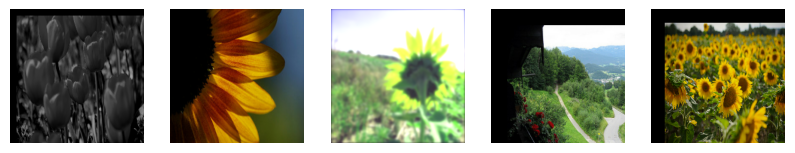

2023-11-24 16:22:36.591812: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


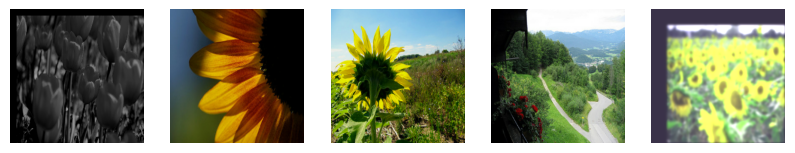

In [12]:
sample_images = next(iter(dataset_one))

plt.figure(figsize=(10, 10))
for n in range(5):
    ax = plt.subplot(1, 5, n+1)
    plt.imshow(sample_images[n])
    plt.axis('off')
plt.show()

sample_images = next(iter(dataset_two))

plt.figure(figsize=(10, 10))
for n in range(5):
    ax = plt.subplot(1, 5, n+1)
    plt.imshow(sample_images[n])
    plt.axis('off')
plt.show()

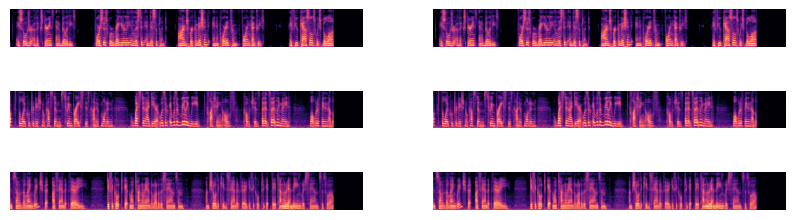

In [13]:
sample_pairs = next(iter(train_dataset))

plt.figure(figsize=(10, 3))
for i in range(3):
    audio_pair = sample_pairs[i]
    plt.subplot(3,2,(2*i)+1)
    plt.imshow(audio_pair[:,:,0], origin="lower", cmap=plt.get_cmap("magma"))
    plt.axis('off')
    plt.subplot(3,2,(2*i)+2)
    plt.imshow(audio_pair[:,:,1], origin="lower", cmap=plt.get_cmap("magma"))
    plt.axis('off')

The network architectures are based on the **Method (Baseline settings)** section of the paper. 

## Encoder ($f$)

This includes ResNet50 as a backbone and another MLP for projection. Note that I have reduced the architectures here leaving ResNet50 backbone intact. 

In [14]:
# (64, 128, 1201, 2)
# (64, 224, 224, 3)
def get_encoder():
    base_model = tf.keras.applications.ResNet50(include_top=False,
        weights=None, input_shape=(128, 1201, 1))
    base_model.trainable = True

    inputs = tf.keras.layers.Input((128, 1201, 1))
    x = base_model(inputs, training=True)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(2048, activation='relu', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    z = tf.keras.layers.Dense(2048)(x)

    f = tf.keras.Model(inputs, z)

    return f

## Predictor ($h$)

This includes an MLP. 

In [15]:
def get_predictor():
    inputs = tf.keras.layers.Input((2048, ))
    x = tf.keras.layers.Dense(512, activation='relu', use_bias=False)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    p = tf.keras.layers.Dense(2048)(x)

    h = tf.keras.Model(inputs, p)

    return h

In [16]:
get_encoder().summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 1201, 1)]    0         
                                                                 
 resnet50 (Functional)       (None, 4, 38, 2048)       23581440  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 2048)              4194304   
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 2048)              419635

In [17]:
get_predictor().summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 2048)]            0         
                                                                 
 dense_2 (Dense)             (None, 512)               1048576   
                                                                 
 batch_normalization_1 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dense_3 (Dense)             (None, 2048)              1050624   
                                                                 
Total params: 2101248 (8.02 MB)
Trainable params: 2100224 (8.01 MB)
Non-trainable params: 1024 (4.00 KB)
_________________________________________________________________


The authors have also provided PyTorch-like psuedocode in the paper (how cool!) - 

```python
# f: backbone + projection mlp
# h: prediction mlp
for x in loader: # load a minibatch x with n samples
    x1, x2 = aug(x), aug(x) # random augmentation
    z1, z2 = f(x1), f(x2) # projections, n-by-d
    p1, p2 = h(z1), h(z2) # predictions, n-by-d
    L = D(p1, z2)/2 + D(p2, z1)/2 # loss
    L.backward() # back-propagate
    update(f, h) # SGD update

def D(p, z): # negative cosine similarity
    z = z.detach() # stop gradient
    p = normalize(p, dim=1) # l2-normalize
    z = normalize(z, dim=1) # l2-normalize
    return -(p*z).sum(dim=1).mean()
```

In [18]:
def loss_func(p, z):
    z = tf.stop_gradient(z)
    p = tf.math.l2_normalize(p, axis=1)
    z = tf.math.l2_normalize(z, axis=1)
    return - tf.reduce_mean(tf.reduce_sum((p*z), axis=1))

In [19]:
@tf.function
# def train_step(ds_one, ds_two, f, h, optimizer):
def train_step(ds, f, h, optimizer):
    with tf.GradientTape() as tape:
        audio_1 = ds[:,:,:,0]
        audio_2 = ds[:,:,:,1]
        # z1, z2 = f(ds_one), f(ds_two)
        z1, z2 = f(audio_1), f(audio_2)
        p1, p2 = h(z1), h(z2)
        loss = loss_func(p1, z2)/2 + loss_func(p2, z1)/2
    
    learnable_params = f.trainable_variables + h.trainable_variables
    gradients = tape.gradient(loss, learnable_params)
    optimizer.apply_gradients(zip(gradients, learnable_params))

    return loss

In [20]:
# def train_simsiam(f, h, dataset_one, dataset_two, optimizer, epochs=100):
def train_simsiam(f, h, dataset, optimizer, epochs=100):
    step_wise_loss = []
    epoch_wise_loss = []

    for epoch in tqdm(range(epochs)):
        # for ds_one, ds_two in zip(dataset_one, dataset_two):
        for batch in dataset:
            
            # plt.figure(figsize=(10, 10))
            # for n in range(5):
            #     ax = plt.subplot(1, 5, n+1)
            #     plt.imshow(ds_one[n])
            #     plt.axis('off')
            # plt.show()

            # plt.figure(figsize=(10, 10))
            # for n in range(5):
            #     ax = plt.subplot(1, 5, n+1)
            #     plt.imshow(ds_two[n])
            #     plt.axis('off')
            # plt.show()
            
            # loss = train_step(ds_one, ds_two, f, h, optimizer)
            loss = train_step(batch, f, h, optimizer)
            step_wise_loss.append(loss)

        epoch_wise_loss.append(np.mean(step_wise_loss))

        if epoch % 10 == 0:
            print("epoch: {} loss: {:.3f}".format(epoch + 1, np.mean(step_wise_loss)))

    return epoch_wise_loss, f, h

In [21]:
decay_steps = 500
lr_decayed_fn = tf.keras.experimental.CosineDecay(
    initial_learning_rate=0.01, decay_steps=decay_steps)
optimizer = tf.keras.optimizers.SGD(lr_decayed_fn, momentum=0.6)

f = get_encoder()
h = get_predictor()

# epoch_wise_loss, f, h  = train_simsiam(f, h, dataset_one, dataset_two, optimizer, epochs=50)
epoch_wise_loss, f, h  = train_simsiam(f, h, train_dataset, optimizer, epochs=50)

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
plt.plot(epoch_wise_loss)
plt.grid()
plt.show()

In [ ]:
f.save_weights("projection.h5")
h.save_weights("prediction.h5")